# EDA of Random Forest Classifier on Machine Failure

## Libraries and functions

In [2]:
# 3rd party
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV

import dtreeviz
%config InlineBackend.figure_format = 'retina' # Make visualizations look good
%matplotlib inline

# standard library
import time

# internal imports
from util import make_difference_features, make_multiplicative_features, calculate_and_display_accuracy

# constants
RANDOM_SEED = 42
TEST_SIZE = 0.25

## Preprocessing

In [3]:
raw_data = pd.read_csv('../machine failure.csv')
data = raw_data.copy()

In [4]:
# if the failure is not a twf, hdf, pwf, or osf then it is treated as a non failure
data['Machine failure'] = np.where((data['TWF'] == 1) | (data['HDF'] == 1) | (data['PWF'] == 1) | (data['OSF'] == 1), 1, 0)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int32  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int32(1)

In [6]:
data.drop(['UDI','Product ID', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1, inplace=True)

In [7]:
clean_mapped_data = data.copy()
quality_map = {'L': 1, 'M': 2, 'H': 3}
clean_mapped_data['Type'] = clean_mapped_data['Type'].map(quality_map)

In [8]:
clean_mapped_data.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,2,298.1,308.6,1551,42.8,0,0
1,1,298.2,308.7,1408,46.3,3,0
2,1,298.1,308.5,1498,49.4,5,0
3,1,298.2,308.6,1433,39.5,7,0
4,1,298.2,308.7,1408,40.0,9,0


### Add interaction columns using both difference and multiplication

In [9]:
subtraction_columns = make_difference_features(clean_mapped_data.drop(columns=['Machine failure', 'Type']))
multiplication_columns = make_multiplicative_features(clean_mapped_data.drop(columns=['Machine failure', 'Type']))
clean_mapped_data = pd.concat([clean_mapped_data, subtraction_columns, multiplication_columns], axis=1)

## Split and Standardize

In [10]:
X = clean_mapped_data.drop(columns='Machine failure')
y = clean_mapped_data['Machine failure']
X_map_train, X_map_test, y_map_train, y_map_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y)

In [11]:
scaler = StandardScaler()
columns_to_scale = list(X_map_train.columns)
columns_to_scale.remove('Type')

X_map_train[columns_to_scale] = scaler.fit_transform(X_map_train[columns_to_scale])
X_map_test[columns_to_scale] = scaler.transform(X_map_test[columns_to_scale])

## Mapped data

In [12]:
mapped_model = RandomForestClassifier(random_state=RANDOM_SEED)
mapped_model.fit(X_map_train, y_map_train)

RandomForestClassifier(random_state=42)

### Accuracy - 99.4%

In [13]:
calculate_and_display_accuracy(mapped_model, X_map_train, y_map_train, X_map_test, y_map_test)

Model Training accuracy:                                   0.9999
Model Test accuracy:                                       0.9936
Baseline, Naive model (always guess 0) training accuracy:  0.9669
Baseline, Naive model (always guess 0) test accuracy:      0.9672


(0.9998666666666667, 0.9936, 0.9669333333333333, 0.9672)

In [14]:
mapped_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

### Other metrics: confusion matrix, precision, recall, f1 score, and false positives

In [68]:
test_predictions = mapped_model.predict(X_map_test)

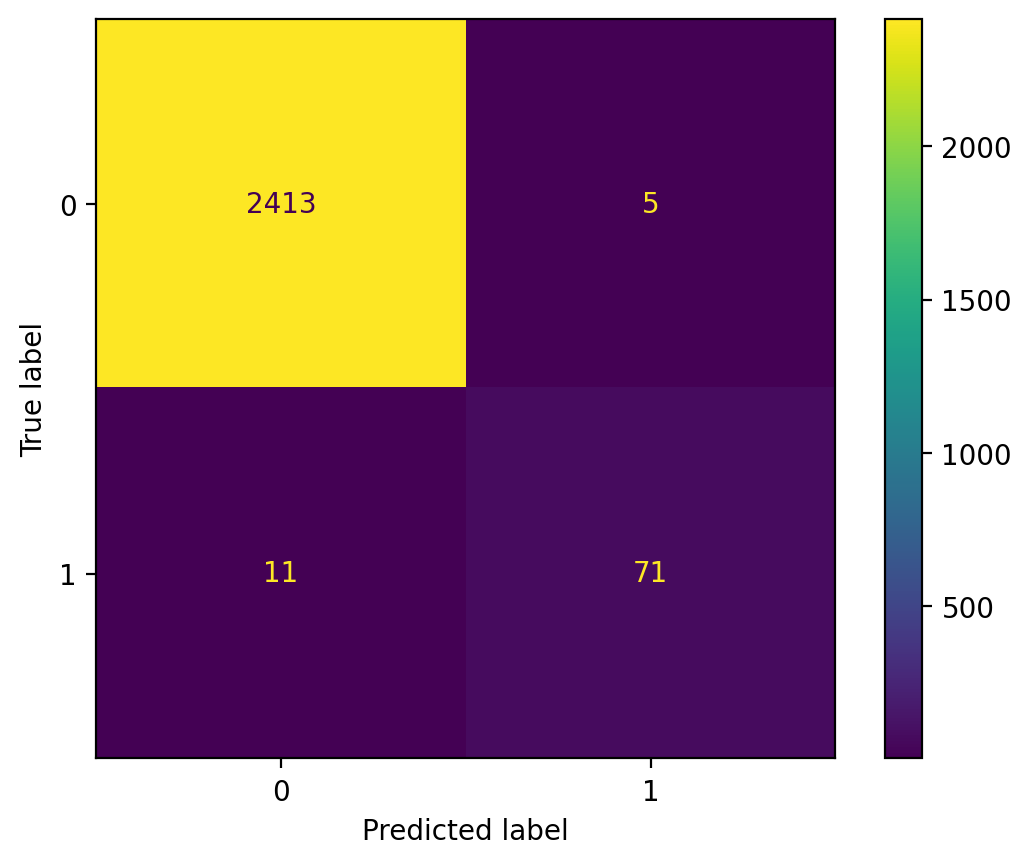

In [69]:
cm = confusion_matrix(y_map_test, test_predictions, labels=mapped_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mapped_model.classes_)
disp.plot()
plt.savefig('random_forest_test_confusion_matrix.svg', format='svg', bbox_inches='tight')

In [76]:
print(f'Precision Score = {precision_score(y_map_test, test_predictions)}')

Precision Score = 0.9342105263157895


In [77]:
print(f'Recall Score = {recall_score(y_map_test, test_predictions)}')

Recall Score = 0.8658536585365854


In [78]:
print(f'F1 Score = {f1_score(y_map_test, test_predictions)}')

F1 Score = 0.8987341772151899


In [70]:
tn, fp, fn, tp = confusion_matrix(y_map_test, test_predictions).ravel()

In [74]:
print(f'False Positive Rate = {fp / (tn + fp)}')

False Positive Rate = 0.0020678246484698098


### SMOTE and ADASYN and TOMEC links

#### SMOTE - 97.6%

In [20]:
smote_resampler = SMOTE(random_state=RANDOM_SEED)
X_map_train_smote, y_map_train_smote = smote_resampler.fit_resample(X_map_train, y_map_train)

In [21]:
smote_rf = RandomForestClassifier(random_state=RANDOM_SEED)
smote_rf.fit(X_map_train_smote, y_map_train_smote)

RandomForestClassifier(random_state=42)

In [22]:
calculate_and_display_accuracy(smote_rf, X_map_train, y_map_train, X_map_test, y_map_test)

Model Training accuracy:                                   1.0
Model Test accuracy:                                       0.976
Baseline, Naive model (always guess 0) training accuracy:  0.9669
Baseline, Naive model (always guess 0) test accuracy:      0.9672


(1.0, 0.976, 0.9669333333333333, 0.9672)

#### ADASYN - 97.3%

In [23]:
adasyn_resampler = ADASYN(random_state=RANDOM_SEED)
X_map_train_adasyn, y_map_train_adasyn = adasyn_resampler.fit_resample(X_map_train, y_map_train)

In [24]:
adasyn_rf = RandomForestClassifier(random_state=RANDOM_SEED)
adasyn_rf.fit(X_map_train_adasyn, y_map_train_adasyn)

RandomForestClassifier(random_state=42)

In [25]:
calculate_and_display_accuracy(adasyn_rf, X_map_train, y_map_train, X_map_test, y_map_test)

Model Training accuracy:                                   1.0
Model Test accuracy:                                       0.9728
Baseline, Naive model (always guess 0) training accuracy:  0.9669
Baseline, Naive model (always guess 0) test accuracy:      0.9672


(1.0, 0.9728, 0.9669333333333333, 0.9672)

#### TOMEC links - 99.2%

In [26]:
tomek_resampler = TomekLinks()
X_map_train_tomek, y_map_train_tomek = tomek_resampler.fit_resample(X_map_train, y_map_train)

In [27]:
tomek_rf = RandomForestClassifier(random_state=RANDOM_SEED)
tomek_rf.fit(X_map_train_tomek, y_map_train_tomek)

RandomForestClassifier(random_state=42)

In [28]:
calculate_and_display_accuracy(tomek_rf, X_map_train, y_map_train, X_map_test, y_map_test)

Model Training accuracy:                                   0.9997
Model Test accuracy:                                       0.9924
Baseline, Naive model (always guess 0) training accuracy:  0.9669
Baseline, Naive model (always guess 0) test accuracy:      0.9672


(0.9997333333333334, 0.9924, 0.9669333333333333, 0.9672)

#### SMOTETOMEC links - 97.5%

In [29]:
stomek_resampler = SMOTETomek(random_state=RANDOM_SEED)
X_map_train_stomek, y_map_train_stomek = stomek_resampler.fit_resample(X_map_train, y_map_train)

In [30]:
stomek_rf = RandomForestClassifier(random_state=RANDOM_SEED)
stomek_rf.fit(X_map_train_stomek, y_map_train_stomek)

RandomForestClassifier(random_state=42)

In [31]:
calculate_and_display_accuracy(stomek_rf, X_map_train, y_map_train, X_map_test, y_map_test)

Model Training accuracy:                                   0.9999
Model Test accuracy:                                       0.9748
Baseline, Naive model (always guess 0) training accuracy:  0.9669
Baseline, Naive model (always guess 0) test accuracy:      0.9672


(0.9998666666666667, 0.9748, 0.9669333333333333, 0.9672)

#### balanced rf - 85.4%

In [32]:
clf = BalancedRandomForestClassifier(
    sampling_strategy="all", replacement=True, max_depth=3, random_state=RANDOM_SEED)

In [33]:
import warnings
warnings.filterwarnings('ignore')

clf.fit(X_map_train, y_map_train)
warnings.filterwarnings('default')

In [34]:
calculate_and_display_accuracy(clf, X_map_train, y_map_train, X_map_test, y_map_test)

Model Training accuracy:                                   0.8592
Model Test accuracy:                                       0.8544
Baseline, Naive model (always guess 0) training accuracy:  0.9669
Baseline, Naive model (always guess 0) test accuracy:      0.9672


(0.8592, 0.8544, 0.9669333333333333, 0.9672)

## Hyperparameter tuning

### grid search

In [15]:
rf = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)

In [53]:
search_params = {'min_samples_leaf': [5, 10, 15],
                 'max_features': [0.3, 0.5, 0.7, 0.9],
                 'max_depth': [8, 10, 12],
                 'n_estimators': [150, 160, 170]
                }

In [54]:
start_time = time.perf_counter()
grid = GridSearchCV(rf, param_grid=search_params, cv=3, scoring='accuracy', n_jobs=-1)
grid_model = grid.fit(X_map_train, y_map_train)
print(f'Elapsed seconds: {time.perf_counter() - start_time:.1f}')

Elapsed seconds: 287.5


In [55]:
grid_model.best_params_

{'max_depth': 12,
 'max_features': 0.9,
 'min_samples_leaf': 5,
 'n_estimators': 160}

In [56]:
grid_model.best_score_

0.9938666666666666

In [17]:
grid_rf = RandomForestClassifier(random_state=RANDOM_SEED, max_depth=12, max_features=0.9, min_samples_leaf=5,
                                 n_estimators=160)
grid_rf.fit(X_map_train, y_map_train)

RandomForestClassifier(max_depth=12, max_features=0.9, min_samples_leaf=5,
                       n_estimators=160, random_state=42)

In [18]:
calculate_and_display_accuracy(grid_rf, X_map_train, y_map_train, X_map_test, y_map_test)

Model Training accuracy:                                   0.9951
Model Test accuracy:                                       0.9944
Baseline, Naive model (always guess 0) training accuracy:  0.9669
Baseline, Naive model (always guess 0) test accuracy:      0.9672


(0.9950666666666667, 0.9944, 0.9669333333333333, 0.9672)

### genetic algorithm search

In [16]:
!python ga_hyperparameter_search.py

gen	nevals	max   	avg     
0  	20    	0.9936	0.986507
1  	14    	0.994 	0.992027
2  	13    	0.994 	0.992927
3  	15    	0.994 	0.993353
4  	14    	0.994133	0.99314 
5  	14    	0.9944  	0.9936  
Elapsed seconds: 214.1
- Best solution is: 
params =  min_samples_leaf=5, max_features=0.88, max_depth=13, estimators=115
Accuracy = 0.99440


In [19]:
ga_rf = RandomForestClassifier(random_state=RANDOM_SEED, max_depth=13, max_features=0.88, min_samples_leaf=5,
                                 n_estimators=115)
ga_rf.fit(X_map_train, y_map_train)

RandomForestClassifier(max_depth=13, max_features=0.88, min_samples_leaf=5,
                       n_estimators=115, random_state=42)

In [20]:
calculate_and_display_accuracy(ga_rf, X_map_train, y_map_train, X_map_test, y_map_test)

Model Training accuracy:                                   0.9951
Model Test accuracy:                                       0.9944
Baseline, Naive model (always guess 0) training accuracy:  0.9669
Baseline, Naive model (always guess 0) test accuracy:      0.9672


(0.9950666666666667, 0.9944, 0.9669333333333333, 0.9672)

## Tree Visualization 

In [34]:
adasyn_rf.estimators_[0]

DecisionTreeClassifier(max_features='sqrt', random_state=1608637542)

In [40]:
viz_model = dtreeviz.model(model.estimators_[0],
                           X_train=X_train, y_train=y_train,
                           feature_names=X_train_adasyn.columns,
                           target_name='Heat Dissipation Failure', class_names=['No Failure', 'Failure'])

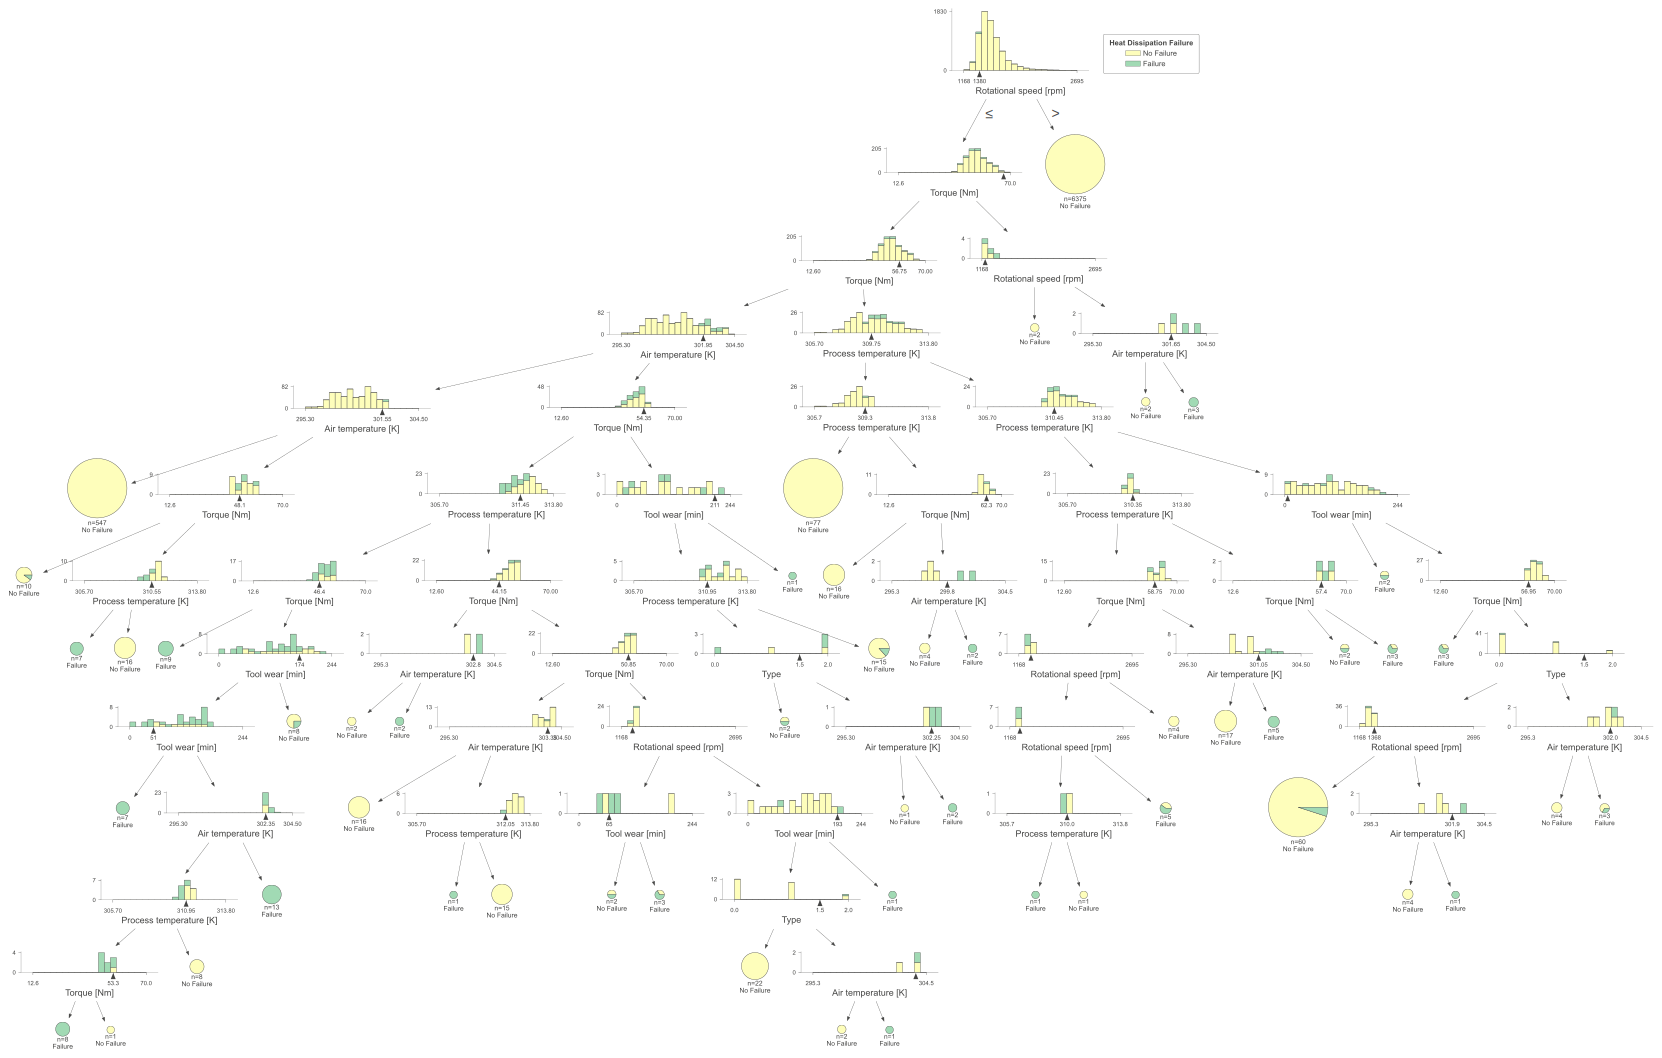

In [41]:
viz_model.view()

## Dummied data

### preprocessing

In [36]:
clean_dummied_data = pd.get_dummies(data, columns=['Type'])
clean_dummied_data.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Type_H,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,False,False,True
1,298.2,308.7,1408,46.3,3,0,False,True,False
2,298.1,308.5,1498,49.4,5,0,False,True,False
3,298.2,308.6,1433,39.5,7,0,False,True,False
4,298.2,308.7,1408,40.0,9,0,False,True,False


In [37]:
subtraction_columns = make_difference_features(clean_dummied_data.drop(columns=['Machine failure', 'Type_H', 'Type_L', 'Type_M']))
multiplication_columns = make_multiplicative_features(clean_dummied_data.drop(columns=['Machine failure',  'Type_H', 'Type_L', 'Type_M']))
clean_dummied_data = pd.concat([clean_dummied_data, subtraction_columns, multiplication_columns], axis=1)

In [40]:
X = clean_dummied_data.drop(columns='Machine failure')
y = clean_dummied_data['Machine failure']
X_dummy_train, X_dummy_test, y_dummy_train, y_dummy_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y)

In [43]:
scaler = StandardScaler()
columns_to_scale = list(X_dummy_train.columns)
columns_to_scale.remove('Type_H')
columns_to_scale.remove('Type_L')
columns_to_scale.remove('Type_M')

X_dummy_train[columns_to_scale] = scaler.fit_transform(X_dummy_train[columns_to_scale])
X_dummy_test[columns_to_scale] = scaler.transform(X_dummy_test[columns_to_scale])

### random forest

In [44]:
model = RandomForestClassifier(random_state=RANDOM_SEED)
model.fit(X_dummy_train, y_dummy_train)

RandomForestClassifier(random_state=42)

### accuracy - 99.3%

In [45]:
calculate_and_display_accuracy(model, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test)

Model Training accuracy:                                   0.9999
Model Test accuracy:                                       0.9932
Baseline, Naive model (always guess 0) training accuracy:  0.9669
Baseline, Naive model (always guess 0) test accuracy:      0.9672


(0.9998666666666667, 0.9932, 0.9669333333333333, 0.9672)

### SMOTE and ADASYN and TOMEC links

#### SMOTE - 97.5%

In [46]:
smote_resampler = SMOTE(random_state=RANDOM_SEED)
X_train_smote, y_train_smote = smote_resampler.fit_resample(X_dummy_train, y_dummy_train)

In [47]:
smote_rf = RandomForestClassifier(random_state=RANDOM_SEED)
smote_rf.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

In [48]:
calculate_and_display_accuracy(smote_rf, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test)

Model Training accuracy:                                   1.0
Model Test accuracy:                                       0.9748
Baseline, Naive model (always guess 0) training accuracy:  0.9669
Baseline, Naive model (always guess 0) test accuracy:      0.9672


(1.0, 0.9748, 0.9669333333333333, 0.9672)

#### ADASYN - 97.2%

In [49]:
adasyn_resampler = ADASYN(random_state=RANDOM_SEED)
X_train_adasyn, y_train_adasyn = adasyn_resampler.fit_resample(X_dummy_train, y_dummy_train)

In [50]:
adasyn_rf = RandomForestClassifier(random_state=RANDOM_SEED)
adasyn_rf.fit(X_train_adasyn, y_train_adasyn)

RandomForestClassifier(random_state=42)

In [51]:
calculate_and_display_accuracy(adasyn_rf, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test)

Model Training accuracy:                                   1.0
Model Test accuracy:                                       0.9724
Baseline, Naive model (always guess 0) training accuracy:  0.9669
Baseline, Naive model (always guess 0) test accuracy:      0.9672


(1.0, 0.9724, 0.9669333333333333, 0.9672)

#### TOMEC links - 99.1%

In [61]:
tomek_resampler = TomekLinks()
X_train_tomek, y_train_tomek = tomek_resampler.fit_resample(X_dummy_train, y_dummy_train)

In [62]:
tomek_rf = RandomForestClassifier(random_state=RANDOM_SEED)
tomek_rf.fit(X_train_tomek, y_train_tomek)

RandomForestClassifier(random_state=42)

In [63]:
calculate_and_display_accuracy(tomek_rf, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test)

Model Training accuracy:                                   0.9997
Model Test accuracy:                                       0.9916
Baseline, Naive model (always guess 0) training accuracy:  0.9669
Baseline, Naive model (always guess 0) test accuracy:      0.9672


(0.9997333333333334, 0.9916, 0.9669333333333333, 0.9672)

#### SMOTETOMEC links - 97.6%

In [55]:
stomek_resampler = SMOTETomek(random_state=RANDOM_SEED)
X_train_stomek, y_train_stomek = stomek_resampler.fit_resample(X_dummy_train, y_dummy_train)

In [56]:
stomek_rf = RandomForestClassifier(random_state=RANDOM_SEED)
stomek_rf.fit(X_train_stomek, y_train_stomek)

RandomForestClassifier(random_state=42)

In [57]:
calculate_and_display_accuracy(stomek_rf, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test)

Model Training accuracy:                                   0.9997
Model Test accuracy:                                       0.976
Baseline, Naive model (always guess 0) training accuracy:  0.9669
Baseline, Naive model (always guess 0) test accuracy:      0.9672


(0.9997333333333334, 0.976, 0.9669333333333333, 0.9672)

#### balanced rf - 84.6%

In [58]:
clf = BalancedRandomForestClassifier(
    sampling_strategy="all", replacement=True, max_depth=3, random_state=RANDOM_SEED)

In [59]:
import warnings
warnings.filterwarnings('ignore')

clf.fit(X_dummy_train, y_dummy_train)
warnings.filterwarnings('default')

In [60]:
calculate_and_display_accuracy(clf, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test)

Model Training accuracy:                                   0.8497
Model Test accuracy:                                       0.846
Baseline, Naive model (always guess 0) training accuracy:  0.9669
Baseline, Naive model (always guess 0) test accuracy:      0.9672


(0.8497333333333333, 0.846, 0.9669333333333333, 0.9672)

## Old exploration and processing

### exploration

In [5]:
df = pd.read_csv('../data/machine_failure.csv', index_col=0)

In [4]:
df.head(2)

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
UDI,,,,,,,,,,,,,
1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0


In [5]:
df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].value_counts()

TWF  HDF  PWF  OSF  RNF
0    0    0    0    0      9652
     1    0    0    0       106
     0    1    0    0        80
          0    1    0        78
1    0    0    0    0        42
0    0    0    0    1        18
          1    1    0        11
     1    0    1    0         6
          1    0    0         3
1    0    0    1    0         2
               0    1         1
          1    1    0         1
dtype: int64

In [8]:
print('---Failures by Type---')
print('twf', 'hdf', 'pwf', 'osf', 'rnf')
print(f"{len(df[df['TWF'] == 1]):<3}", f"{len(df[df['HDF'] == 1]):<3}", f"{len(df[df['PWF'] == 1]):<3}", f"{len(df[df['OSF'] == 1]):<3}", f"{len(df[df['RNF'] == 1]):<3}")


---Failures by Type---
twf hdf pwf osf rnf
46  115 95  98  19 


In [9]:
df['Machine failure'].value_counts()

0    9661
1     339
Name: Machine failure, dtype: int64

In [10]:
a_failure = df[(df['TWF'] == 1) | (df['HDF'] == 1) |  (df['PWF'] == 1) | (df['OSF'] == 1) |  (df['RNF'] == 1)]

In [11]:
a_failure[a_failure['Machine failure'] == 0]

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
UDI,,,,,,,,,,,,,
1222,M16081,M,297.0,308.3,1399,46.4,132,0,0,0,0,0,1
1303,L48482,L,298.6,309.8,1505,45.7,144,0,0,0,0,0,1
1749,H31162,H,298.4,307.7,1626,31.1,166,0,0,0,0,0,1
2073,L49252,L,299.6,309.5,1570,35.5,189,0,0,0,0,0,1
2560,L49739,L,299.3,309.0,1447,50.4,140,0,0,0,0,0,1
3066,M17925,M,300.1,309.2,1687,27.7,95,0,0,0,0,0,1
3453,H32866,H,301.6,310.5,1602,32.3,2,0,0,0,0,0,1
5472,L52651,L,302.7,312.3,1346,61.2,170,0,0,0,0,0,1
5490,L52669,L,302.6,312.1,1499,35.0,215,0,0,0,0,0,1


### Suggested Filtering Method

In [94]:
# use np.where to plug in ones when HDF is true otherwise 0 for all other failures and non-failures
df['target'] = np.where(df['HDF'] == 1, 1, 0)

In [96]:
df[df['OSF'] == 1].head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,target
UDI,,,,,,,,,,,,,,
70,L47249,L,298.9,309.0,1410,65.7,191,1,0,0,1,1,0,0
161,L47340,L,298.4,308.2,1282,60.7,216,1,0,0,0,1,0,0
162,L47341,L,298.3,308.1,1412,52.3,218,1,0,0,0,1,0,0
243,L47422,L,298.0,308.2,1348,58.8,202,1,0,0,0,1,0,0
249,L47428,L,298.0,308.3,1362,56.8,216,1,0,0,0,1,0,0


### preprocessing

In [6]:
# filtered data
# only include HDF positive cases and non-machine failure cases
hdf_df = df[(df['HDF']) | ((df['Machine failure'] == 0) & (df['RNF'] == 0))]

In [7]:
hdf_df['HDF'].value_counts()

0    9643
1     115
Name: HDF, dtype: int64

In [8]:
hdf_df['HDF'].value_counts(normalize=True)

0    0.988215
1    0.011785
Name: HDF, dtype: float64

In [9]:
print('Machine failure with no HDF:', hdf_df[(hdf_df['Machine failure'] == 1) & (hdf_df['HDF'] == 0)].shape[0])
print('No machine failure with HDF:', hdf_df[(hdf_df['Machine failure'] == 0) & (hdf_df['HDF'] == 1)].shape[0])

Machine failure with no HDF: 0
No machine failure with HDF: 0


In [10]:
hdf_df.columns

Index(['Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')

In [11]:
X = hdf_df[['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']].copy()
X['Type'] = X['Type'].map({'L': 0, 'M': 1, 'H': 2})
X.head(2)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
UDI,,,,,,
1,1,298.1,308.6,1551,42.8,0
2,0,298.2,308.7,1408,46.3,3


In [13]:
y = hdf_df['HDF']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED, stratify=y)

In [15]:
y_train.value_counts(normalize=True)

0    0.988248
1    0.011752
Name: HDF, dtype: float64

In [16]:
y_test.value_counts(normalize=True)

0    0.988115
1    0.011885
Name: HDF, dtype: float64